# Análisis del método de máxima entropía para predicción de series temporales

Trabajo de:

* Sara Sofía Quintero Vanegas
* Jesús Ricardo Gandica Velasco
* Karol Vanessa Cuello Ribón
* John Alejandro González González

## Librerías

In [1]:
import pandas as pd
import numpy as np
import holidays
from datetime import datetime, timedelta

from statsmodels.regression.linear_model import burg
from statsmodels.tsa.ar_model import AutoReg

from matplotlib import pyplot as plt
import matplotlib.ticker
import warnings
import memspectrum
from scipy.signal import find_peaks

from memspectrum import MESA

## Caso 1

In [2]:
start_date = '2021-01-01'
end_date = '2024-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

colombia_holidays = holidays.Colombia()

def is_business_day(date):
    # 5 es sabado y 6 es domingo
    return date.weekday() < 5 and date not in colombia_holidays

def get_next_business_day(date):
    prev_date = date
    next_date = date
    while not is_business_day(prev_date):
        prev_date -= timedelta(days=1)
    while not is_business_day(next_date):
        next_date += timedelta(days=1)
    prev_diff = date - prev_date
    next_diff = next_date - date
    if prev_diff == next_diff:
        return prev_date if np.random.rand() < 0.5 else next_date
    return prev_date if prev_diff < next_diff else next_date

business_days = pd.DatetimeIndex([d for d in date_range if is_business_day(d)])
years = business_days.year.unique()

# Contando solo dias habiles
account1_df = pd.DataFrame(index=business_days)
#Contando todos los dias
#account1_df = pd.DataFrame(index=[d for d in pd.DatetimeIndex(date_range)])

# Fechas de variacion mensual, ajustadas para festivos/fines de semana
monthly_variation_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
monthly_variation_dates = [get_next_business_day(d) for d in monthly_variation_dates]

# Fechas de variacion quincenal, ajustadas para festivos/fines de semana
variation_15day_dates = pd.date_range(start=start_date, end=end_date, freq='15D')
variation_15day_dates = [get_next_business_day(d) for d in variation_15day_dates]

# Naturaleza de las variaciones mensuales y quincenales, una debe ser inversa a la otra para que no crezca o decrezca indefinidamente
monthly_variation_sign = 1 if np.random.rand() < 0.5 else -1
variation_15day_sign = -monthly_variation_sign 

# Escala de las variaciones, un valor aleatorio entre 5% y 15% para las mensuales, las quincenalse seran la mitad para que cancelen, pueden tener un ruido si se quiere
monthly_scale = np.random.uniform(0.05, 0.15)
variation_15day_scale = 0.5*monthly_scale


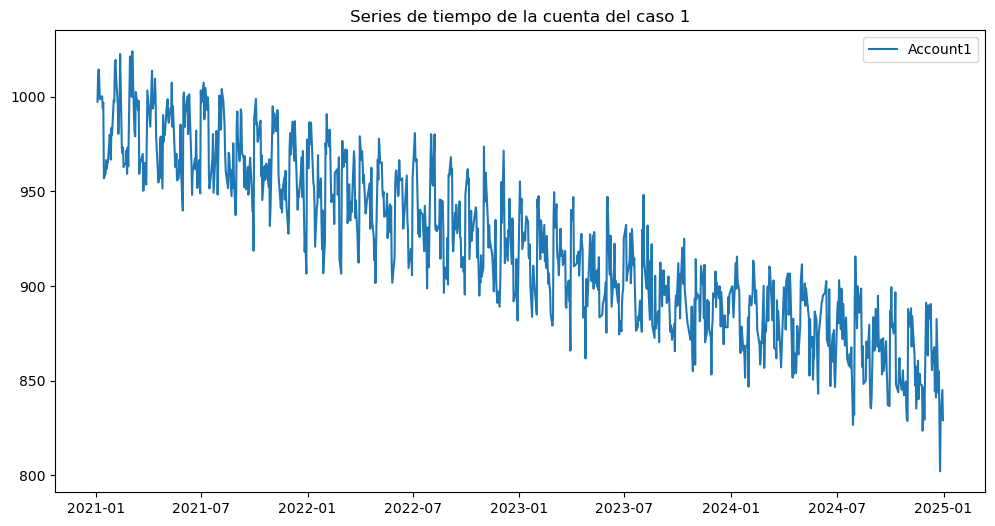

In [3]:
account1_df['Account1'] = 1000.0
account1_df['cumulative_return'] = 1.0
account1_df['daily_return'] = 0.0

# Variaciones mensuales cuenta 1
for date in monthly_variation_dates:
    date = pd.Timestamp(date)
    if date in account1_df.index:
        variation = monthly_variation_sign * monthly_scale
        account1_df.loc[date, 'daily_return'] += variation

# Variaciones quincenales cuenta 1
for date in variation_15day_dates:
    date = pd.Timestamp(date)
    if date in account1_df.index:
        variation = variation_15day_sign * variation_15day_scale
        account1_df.loc[date, 'daily_return'] += variation

account1_df['cumulative_return'] = (1 + account1_df['daily_return']).cumprod()
# Ruido de un (1% diario + variaciones)* escala
account1_df['Account1'] = 1000.0 * (account1_df['cumulative_return']+ 0.01* np.random.normal(0, 1, len(account1_df)))

plt.figure(figsize=(12, 6))
plt.plot(account1_df['Account1'], label='Account1')
plt.title('Series de tiempo de la cuenta del caso 1')
plt.legend()
plt.show()

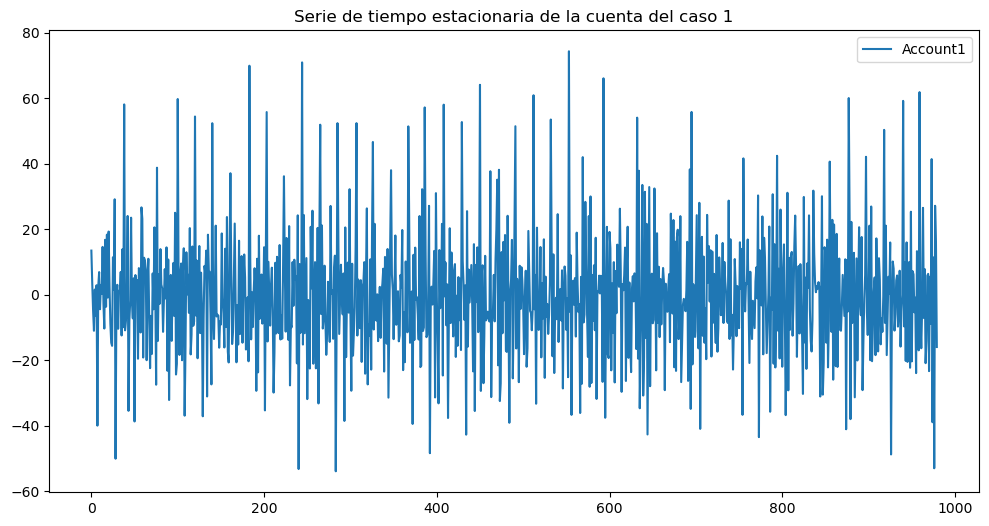

In [4]:
estacionario1 = np.diff(account1_df['Account1'])
plt.figure(figsize=(12, 6))
plt.plot(estacionario1, label='Account1')
plt.title('Serie de tiempo estacionaria de la cuenta del caso 1')
plt.legend()

### Determinar el grado

In [5]:
# Normalizar los datos
data = (account1_df['Account1'] - account1_df['Account1'].mean()) / account1_df['Account1'].std()
data = data.values

# Definir el rango de órdenes a probar
max_order = 200
aic_values = []
bic_values = []

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for order in range(1, max_order + 1):
        model = AutoReg(data, lags=order).fit()
        aic_values.append(model.aic)
        bic_values.append(model.bic)


# Obtener el orden óptimo
optimal_order_aic = np.argmin(aic_values) + 1
optimal_order_bic = np.argmin(bic_values) + 1
print(f"Orden óptimo según AIC: {optimal_order_aic}")
print(f"Orden óptimo según BIC: {optimal_order_bic}")

#optimal_order= 3
optimal_order = optimal_order_aic
print(f"Orden óptimo seleccionado (AIC): {optimal_order}")

Orden óptimo según AIC: 63
Orden óptimo según BIC: 21
Orden óptimo seleccionado (AIC): 63


### Determinar el espectro (nosotros, frecuencia)

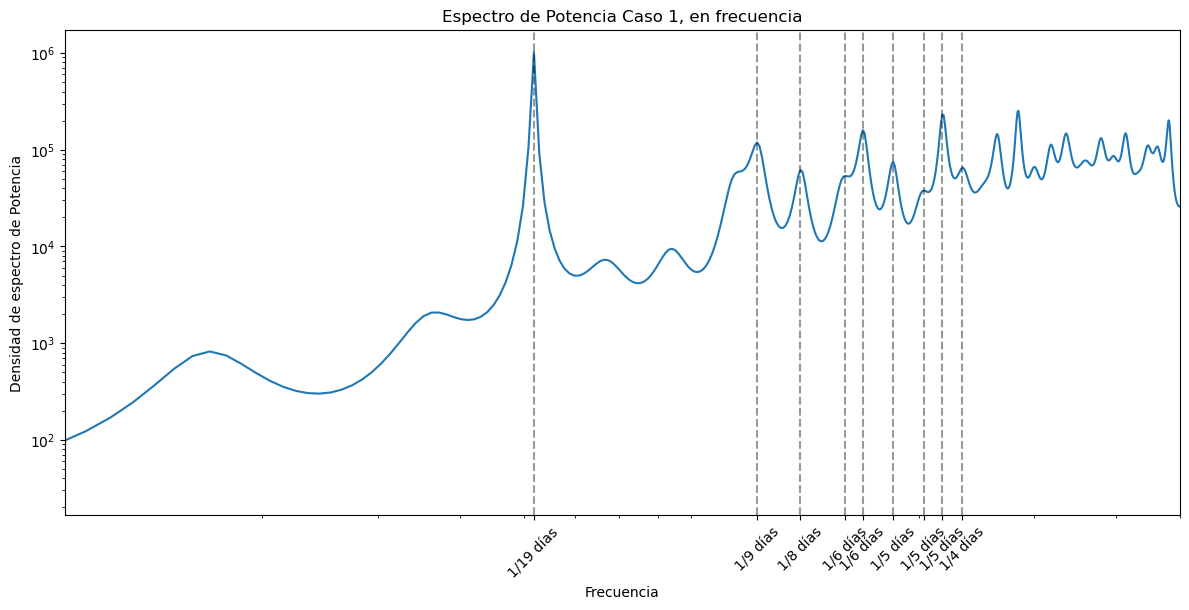

In [6]:
# Estimación del modelo AR usando el algoritmo de Burg para maximizar la entropía
data = account1_df['Account1'].values
data = np.diff(data)
a_k, sigma_w = burg(data, order=optimal_order)

# Cálculo del espectro de potencia utilizando la función de transferencia del modelo AR
def power_spectrum_transfer_function(a_k, sigma_w, num_freqs=512):
    freqs = np.linspace(0, 0.5, num_freqs)
    power_spectrum = np.zeros_like(freqs)

    for i, f in enumerate(freqs):
        denominator = 1 + np.sum([a_k[k] * np.exp(-1j * 2 * np.pi * f * (k)) for k in range(len(a_k))])        
        power_spectrum[i] = sigma_w ** 2 / (np.abs(denominator) ** 2)

    return freqs, power_spectrum

freqs, P_f = power_spectrum_transfer_function(a_k, sigma_w)

#Detección de picos
peaks, _ = find_peaks(P_f, height=1e4) 

plt.figure(figsize=(12, 6))

f_values = []
f_names = []

for peak in peaks:
    #plt.axvline(freqs[peak], color='b', linestyle='--')
    f_values.append(freqs[peak])
    f_names.append(f'{freqs[peak]:.2f} Hz')
      
dias = [1/f for f in f_values]
dias = [round(d) for d in dias]

f_names2 = [f'1/{d} días' for d in dias]    

plt.loglog(freqs,P_f)
#plt.plot(freqs[peaks], P_f[peaks], "x", label="Picos detectados")  # Marca los picos con 'x'
plt.xlabel("Frecuencia")
plt.ylabel("Densidad de espectro de Potencia")
plt.xlim([0.01, 0.5])

f_values = f_values[:9]

for f_val in f_values:
    plt.axvline(f_val, ls = '--', c= 'black', alpha = 0.4)
ax = plt.gca()

ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator((f_values)))
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter((f_names2)))

plt.xticks(rotation=45)

plt.tight_layout()
plt.title("Espectro de Potencia Caso 1, en frecuencia")
plt.show()

### Determinar el espectro de potencia (ellos, periodo)

C:\Users\usuario\AppData\Local\Temp\ipykernel_20748\420540749.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/frequencies, power_spectrum, color='purple')


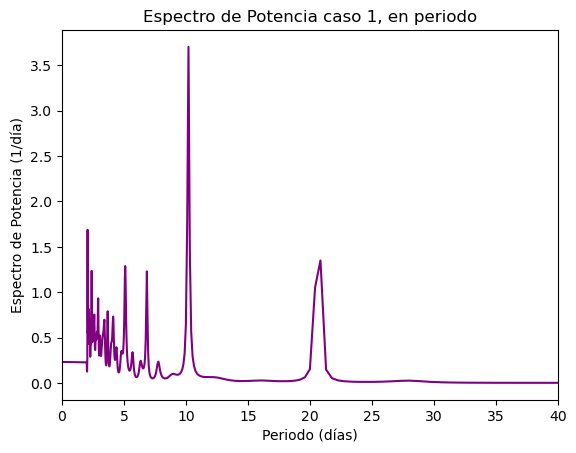

In [7]:
data = account1_df['Account1'].values 
data = np.diff(data, n=1)

# Parámetros de muestreo 
dt, T = 1, len(data) ## Intervalo de muestreo en 1 día, longitud de la serie de tiempo

f = np.arange(1/(10*24), 0.5, 1/T)

m = MESA()

# Ajustar el modelo a los datos
m.solve(data)

# Calcular la Densidad Espectral de Potencia (PSD)
frequencies, psd = m.spectrum(dt)

#Hallar picos
peaks2, _ = find_peaks(psd, height=1e4)

# Convertir la PSD al Espectro de Potencia
resolution_bandwidth = frequencies[1] - frequencies[0]
power_spectrum = psd * resolution_bandwidth

# Graficar el Espectro de Potencia
plt.plot(1/frequencies, power_spectrum, color='purple')
plt.xlim([0, 40])
plt.xlabel("Periodo (días)")
plt.ylabel("Espectro de Potencia (1/día)")
plt.title("Espectro de Potencia caso 1, en periodo")
plt.show()

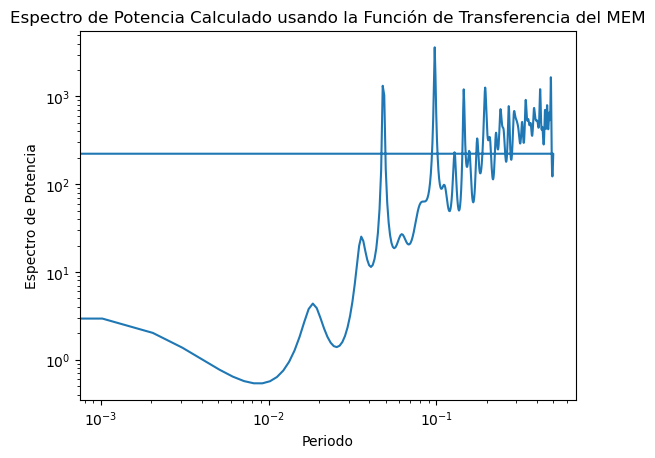

In [8]:
plt.loglog(frequencies, psd)
# plt.axvline(10.3, ls = '--', c= 'k')
# plt.axvline(20.5, ls = '--', c= 'k')
plt.xlabel("Periodo")
plt.ylabel("Espectro de Potencia")
plt.title("Espectro de Potencia Calculado usando la Función de Transferencia del MEM")
plt.show()

## Caso 2

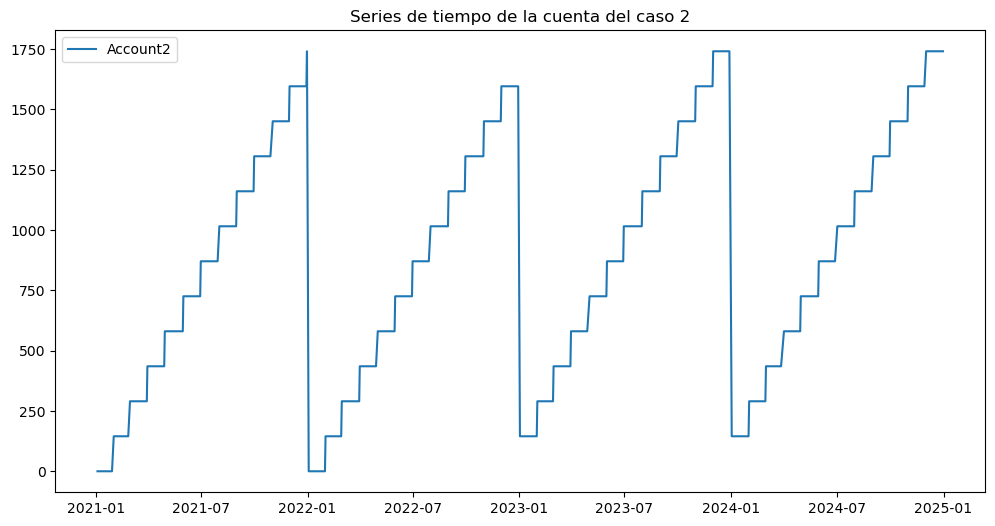

In [9]:
### Cuenta 2: Varia cada mes, se resetea cada año ###
np.random.seed(42)
account2_df = pd.DataFrame(index=business_days)

monthly_variation_sign_acc2 = 1 if np.random.rand() < 0.5 else -1
monthly_scale_acc2 = np.random.uniform(50, 150)  # Constante aleatoria entre 50 y 150

# Aplicar variaciones mensuales y resetear cada año
for year in years:
    dates_in_year = account2_df[account2_df.index.year == year].index
    # Resetear Account2 al inicio del año
    first_date = dates_in_year[0]
    account2_df.loc[first_date, 'Account2'] = 0.0
    # Fechas de variación mensual para el año
    monthly_dates_in_year = [d for d in monthly_variation_dates if d.year == year]
    for date in monthly_dates_in_year:
        date = pd.Timestamp(date)
        if date in account2_df.index:
            prev_value = account2_df.loc[:date, 'Account2'].ffill().iloc[-1]
            account2_df.loc[date, 'Account2'] = prev_value + (monthly_variation_sign_acc2 * monthly_scale_acc2)
    # Rellenar las variaciones
    account2_df.loc[dates_in_year, 'Account2'] = account2_df.loc[dates_in_year, 'Account2'].ffill()

plt.figure(figsize=(12, 6))
plt.plot(account2_df['Account2'], label='Account2')
plt.title('Series de tiempo de la cuenta del caso 2')
plt.legend()

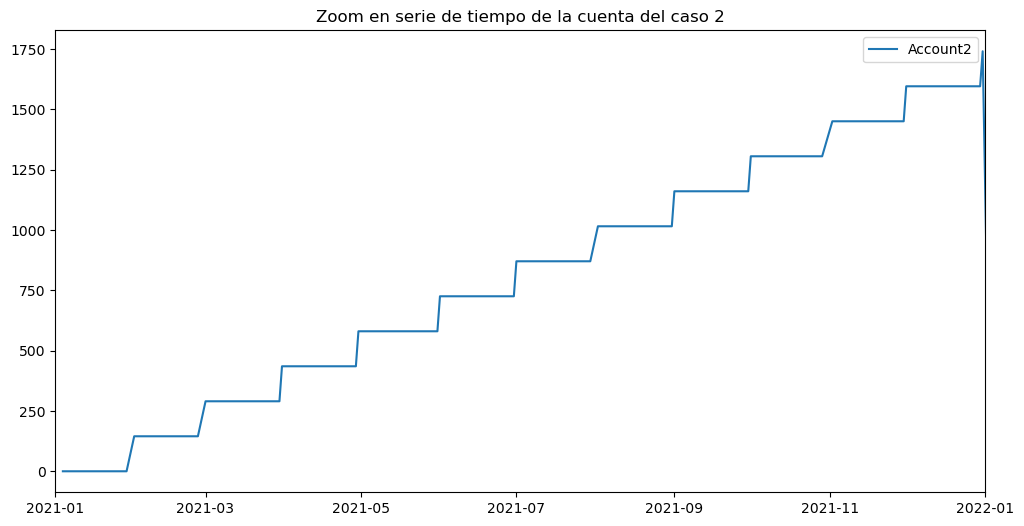

In [10]:
#Zoom

plt.figure(figsize=(12, 6))
plt.plot(account2_df['Account2'], label='Account2')
plt.xlim([pd.Timestamp('2021-01-01'), pd.Timestamp('2022-01-01')])
plt.title('Zoom en serie de tiempo de la cuenta del caso 2')
plt.legend()

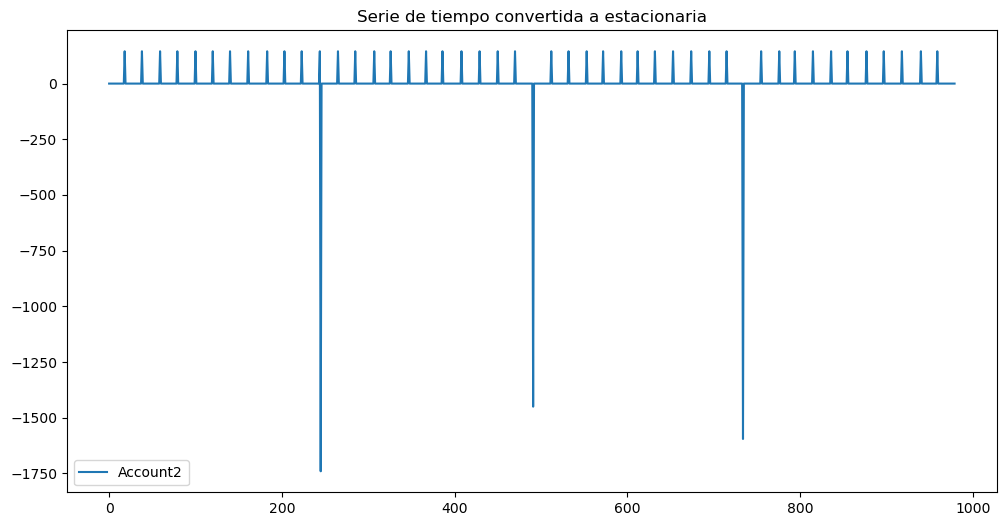

In [11]:
estacionario2 = np.diff(account2_df['Account2'])
plt.figure(figsize=(12, 6))
plt.plot(estacionario2, label='Account2')
plt.title("Serie de tiempo convertida a estacionaria")
plt.legend()

### Determinar el grado

In [12]:
# Normalizar los datos
data = (account2_df['Account2'] - account2_df['Account2'].mean()) / account2_df['Account2'].std()

# Definir el rango de órdenes a probar
max_order = 200
aic_values = []
bic_values = []

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for order in range(1, max_order + 1):
        model = AutoReg(data, lags=order).fit()
        aic_values.append(model.aic)
        bic_values.append(model.bic)


# Obtener el orden óptimo
optimal_order_aic = np.argmin(aic_values) + 1
optimal_order_bic = np.argmin(bic_values) + 1
print(f"Orden óptimo según AIC: {optimal_order_aic}")
print(f"Orden óptimo según BIC: {optimal_order_bic}")

#optimal_order= 3
optimal_order = optimal_order_bic
print(f"Orden óptimo seleccionado (AIC): {optimal_order}")

Orden óptimo según AIC: 1
Orden óptimo según BIC: 1
Orden óptimo seleccionado (AIC): 1


### Determinar el espectro (nosotros, frecuencia)

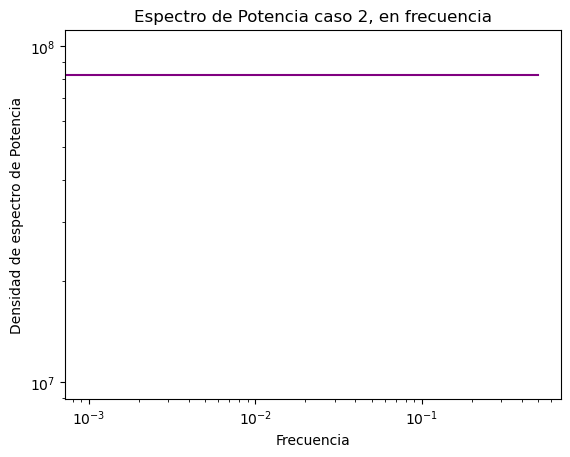

In [13]:
# Estimación del modelo AR usando el algoritmo de Burg para maximizar la entropía
data = account2_df['Account2'].values
data = np.diff(data)

a_k, sigma_w = burg(data, order=optimal_order)

# Cálculo del espectro de potencia utilizando la función de transferencia del modelo AR
def power_spectrum_transfer_function(a_k, sigma_w, num_freqs=512):
    freqs = np.linspace(0, 0.5, num_freqs)
    power_spectrum = np.zeros_like(freqs)

    for i, f in enumerate(freqs):
        denominator = 1 + np.sum([a_k[k] * np.exp(-1j * 2 * np.pi * f * (k)) for k in range(len(a_k))])
        power_spectrum[i] = sigma_w ** 2 / (np.abs(denominator) ** 2)

    return freqs, power_spectrum

freqs, P_f = power_spectrum_transfer_function(a_k, sigma_w)

plt.loglog(freqs, P_f, color='purple')
#plt.plot(freqs, P_f)
plt.xlabel("Frecuencia")
plt.ylabel("Densidad de espectro de Potencia")
plt.title("Espectro de Potencia caso 2, en frecuencia")
plt.show()

### Determinar el espectro de potencia (ellos, periodo)

C:\Users\usuario\AppData\Local\Temp\ipykernel_20748\3653298049.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/frequencies, power_spectrum, color='purple')


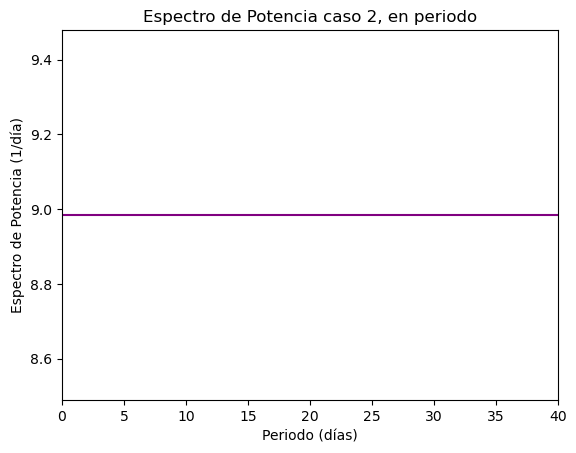

In [14]:
data = account2_df['Account2'].values 
data = np.diff(data, n=1)

# Parámetros de muestreo 
dt, T = 1, len(data) ## Intervalo de muestreo en 1 día, longitud de la serie de tiempo

f = np.arange(1/(10*24), 0.5, 1/T) # Frecuencias de interés

m = MESA()

# Ajustar el modelo a los datos
m.solve(data)

# Calcular la Densidad Espectral de Potencia (PSD)
frequencies, psd = m.spectrum(dt)

peaks2, _ = find_peaks(psd, height=1e4)

# Convertir la PSD al Espectro de Potencia
resolution_bandwidth = frequencies[1] - frequencies[0]
power_spectrum = psd * resolution_bandwidth

# Graficar el Espectro de Potencia
plt.plot(1/frequencies, power_spectrum, color='purple')
plt.xlim([0, 40])
plt.xlabel("Periodo (días)")
plt.ylabel("Espectro de Potencia (1/día)")
plt.title("Espectro de Potencia caso 2, en periodo")
plt.show()

## Caso 3
Caso sacado del ejemplo de la librería memspectrum, https://github.com/martini-alessandro/Maximum-Entropy-Spectrum/blob/main/examples/doc_examples.py

In [15]:
#Intro plot - temperature timeseries
import memspectrum
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

time_series = np.loadtxt('temperature_data_@1h_len5000.dat')

Text(0.5, 1.0, 'Serie de tiempo de temperatura')

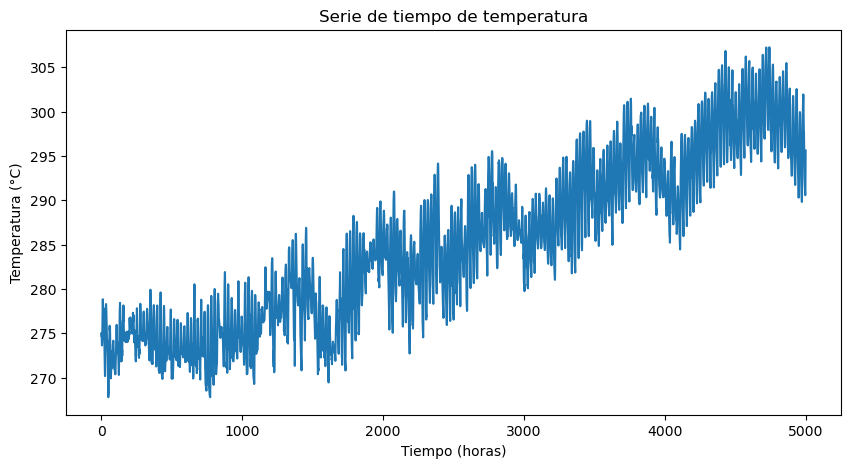

In [16]:
plt.figure(figsize=(10,5))
plt.plot(time_series)
plt.xlabel('Tiempo (horas)')
plt.ylabel('Temperatura (°C)')
plt.title('Serie de tiempo de temperatura')

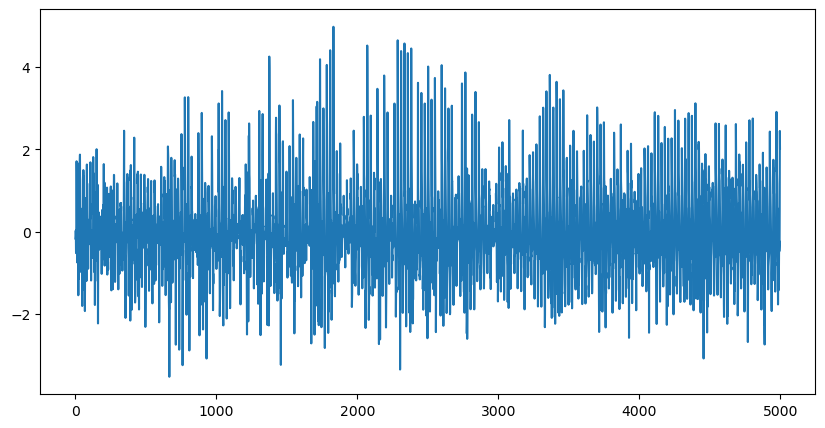

In [17]:
t_diff = np.diff(time_series)
plt.figure(figsize=(10,5))
plt.plot(t_diff)

### Determinar el espectro (ellos, frecuencia)

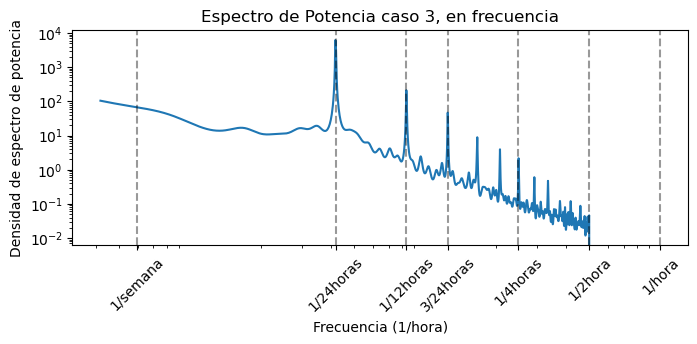

In [18]:
#Intro plot - temperature timeseries

timeseries = np.loadtxt('temperature_data_@1h_len5000.dat')
dt, T = 1, len(timeseries) #Time step, Lenght of the timeseries
N_tstep = 100
f = np.arange(1/(10*24), 0.5, 1/T)
f_values = [1/(7*24), 1/24, 1/12, 1/8, 0.25, 0.5, 1]
f_names = ['1/semana', '1/24horas', '1/12horas', '3/24horas', '1/4horas', '1/2hora','1/hora']

M = memspectrum.MESA()
M.solve(timeseries) #perform the analysis on the given time series (a real/complex np.array)
PSD = M.spectrum(dt, f) #evaluate the PSD on the given frequency grid

peaks3, _ = find_peaks(PSD, height=1e2)

plt.figure(figsize = (3.54*2, 3.54))
plt.loglog(f,PSD)
plt.xlabel('Frecuencia (1/hora)')
plt.ylabel('Densidad de espectro de potencia')
for f_val in f_values:
	plt.axvline(f_val, ls = '--', c= 'k', alpha = 0.4)
ax = plt.gca()

ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator((f_values)))
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter((f_names)))
plt.title("Espectro de Potencia caso 3, en frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('../docs/img/temperature_plot_intro.png', dpi = 200)

In [19]:
1/f[peaks3]

array([24.05773857, 11.99520192])

### Determinar el espectro de potencia (ellos, periodo)

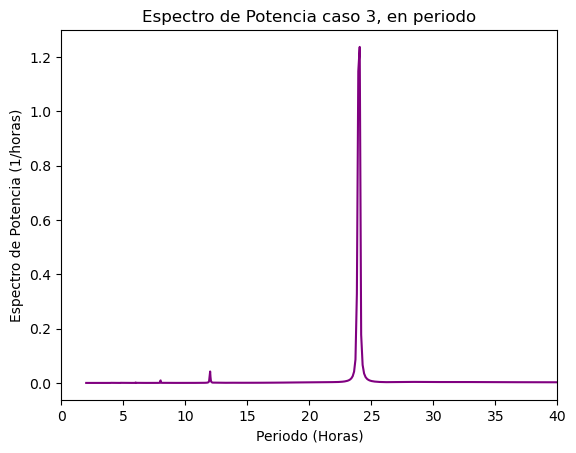

In [20]:
data = timeseries

timeseries = np.loadtxt('temperature_data_@1h_len5000.dat')
dt, T = 1, len(timeseries) #Time step, Lenght of the timeseries
f = np.arange(1/(10*24), 0.5, 1/T)

M = memspectrum.MESA()
M.solve(data) #perform the analysis on the given time series (a real/complex np.array)
psd = M.spectrum(dt, f) #evaluate the PSD on the given frequency grid

peaks2, _ = find_peaks(psd, height=1e4)

# Convertir la PSD al Espectro de Potencia
resolution_bandwidth = 1/T
power_spectrum = psd * resolution_bandwidth

# Graficar el Espectro de Potencia
plt.plot(1/f, power_spectrum, color='purple')
plt.xlim([0, 40])
plt.xlabel("Periodo (Horas)")
plt.ylabel("Espectro de Potencia (1/horas)")
plt.title("Espectro de Potencia caso 3, en periodo")
plt.show()

## Testeo nosotros vs librería memspectrum

In [21]:
timeseries = np.loadtxt('temperature_data_@1h_len5000.dat')
dt, T = 1, len(timeseries) #Time step, Lenght of the timeseries
N_tstep = 100
f = np.arange(1/(10*24), 0.5, 1/T)
f_values = [1/(7*24), 1/24, 1/12, 1/8, 0.25, 0.5, 1]
f_names = ['1/week', '1/day', '2/day', '3/day', '1/4hours', '1/2hours','1/hour']

M = memspectrum.MESA()
M.solve(timeseries) #perform the analysis on the given time series (a real/complex np.array)
PSD = M.spectrum(dt, f) #evaluate the PSD on the given frequency grid

In [22]:
timeseries = np.loadtxt('temperature_data_@1h_len5000.dat')
data = timeseries
#data = np.diff(data, n=1)

# Definir el rango de órdenes a probar
max_order = 200
aic_values = []
bic_values = []

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for order in range(1, max_order + 1):
        model = AutoReg(data, lags=order).fit()
        aic_values.append(model.aic)
        bic_values.append(model.bic)


# Obtener el orden óptimo
optimal_order_aic = np.argmin(aic_values) + 1
optimal_order_bic = np.argmin(bic_values) + 1
print(f"Orden óptimo según AIC: {optimal_order_aic}")
print(f"Orden óptimo según BIC: {optimal_order_bic}")

#optimal_order= 3
optimal_order = optimal_order_aic
print(f"Orden óptimo seleccionado (AIC): {optimal_order}")

# Estimación del modelo AR usando el algoritmo de Burg para maximizar la entropía
a_k, sigma_w = burg(data, order=optimal_order)

# Cálculo del espectro de potencia utilizando la función de transferencia del modelo AR
def power_spectrum_transfer_function(a_k, sigma_w, num_freqs=512):
    freqs = np.linspace(0, 0.5, num_freqs)
    power_spectrum = np.zeros_like(freqs)

    for i, f in enumerate(freqs):
        denominator = 1 + np.sum([a_k[k] * np.exp(-1j * 2 * np.pi * f * (k)) for k in range(len(a_k))])
        power_spectrum[i] = sigma_w ** 2 / (np.abs(denominator) ** 2)
        
    # Convertir frecuencias a periodos (evitando división por cero)
    periods = np.array([1 / f if f != 0 else np.nan for f in freqs])

    return freqs, power_spectrum, periods

freqs, P_f, periodos = power_spectrum_transfer_function(a_k, sigma_w, num_freqs=T)


Orden óptimo según AIC: 193
Orden óptimo según BIC: 74
Orden óptimo seleccionado (AIC): 193


In [23]:
print(len(freqs))
print(len(f))

5000
2480


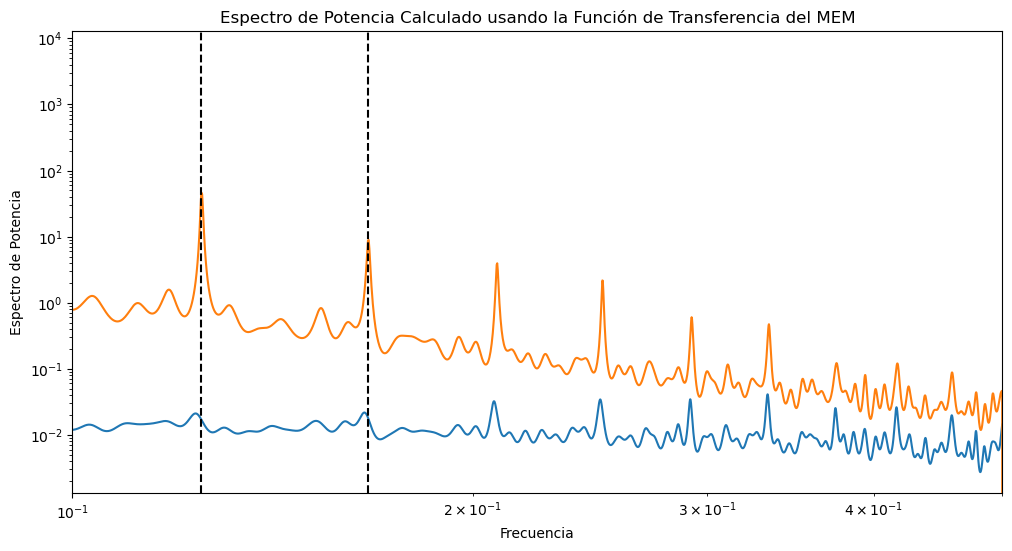

In [24]:
plt.figure(figsize=(12, 6))
#plt.plot(1/freqs, P_f, color='purple')
plt.loglog(freqs,P_f)
plt.loglog(f,PSD)
plt.xlabel("Frecuencia")
plt.ylabel("Espectro de Potencia")
plt.title("Espectro de Potencia Calculado usando la Función de Transferencia del MEM")
plt.xlim([0.1, 0.5])
plt.axvline(1/24, ls = '--', c= 'k')
plt.axvline(1/12, ls = '--', c= 'k')
plt.axvline(1/8, ls = '--', c= 'k')
plt.axvline(1/6, ls = '--', c= 'k')
plt.show()

## Ejemplo de como generar datos con la librería

In [25]:
#Getting the data
from memspectrum.GenerateTimeSeries import generate_data

T, srate = 10., 4096.	
f_grid_analytic = np.linspace(.1, 4096., 1000)
psd_analytic = 1e-10*np.exp((np.log(f_grid_analytic)- np.log(20))**2)
	
t_grid, time_series, f_grid, frequency_series, interpolated_psd = generate_data(f_grid_analytic, psd_analytic, T, srate, seed = 0)

Text(0.5, 1.0, 'Generated time series')

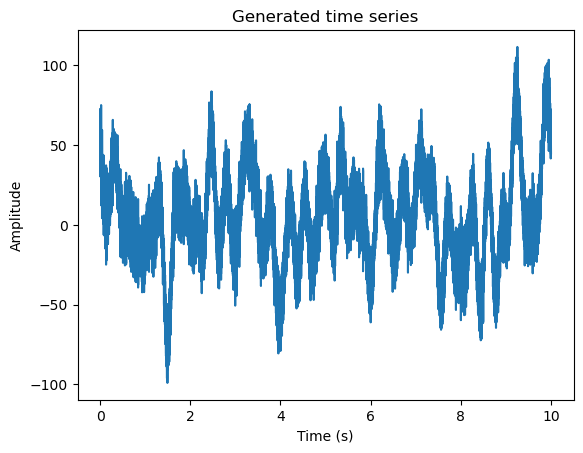

In [26]:
plt.plot(t_grid, time_series)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Generated time series')

Text(0.5, 1.0, 'Estimated PSD (vs true PSD)')

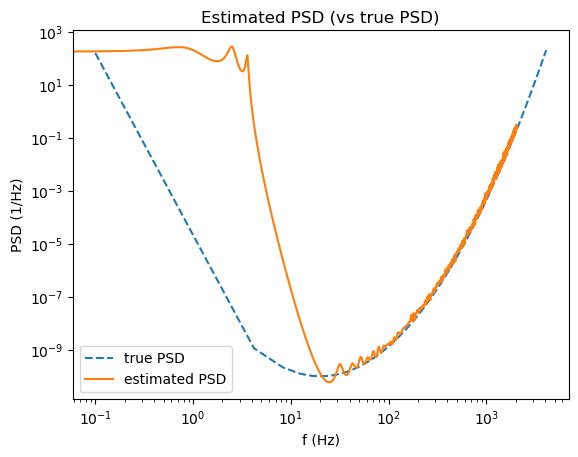

In [27]:
m = memspectrum.MESA()
m.solve(time_series, method = 'Standard', optimisation_method = 'VM')
f_mesa, psd_mesa = m.spectrum(dt = 1./srate, onesided = True)
	
plt.figure()
plt.loglog(f_grid_analytic, psd_analytic, ls = '--', label = 'true PSD')
plt.loglog(f_mesa, psd_mesa, label = 'estimated PSD')
plt.xlabel('f (Hz)')
plt.ylabel('PSD (1/Hz)')
plt.legend()
plt.title('Estimated PSD (vs true PSD)')

Text(0.5, 1.0, 'Estimated PSD (vs true PSD)')

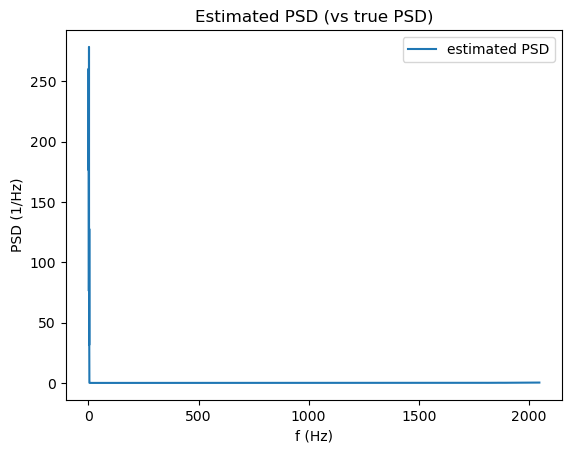

In [28]:
plt.figure()
plt.plot(f_mesa, psd_mesa, label = 'estimated PSD')
plt.xlabel('f (Hz)')
plt.ylabel('PSD (1/Hz)')
plt.legend()
plt.title('Estimated PSD (vs true PSD)')